Importing Libraries

In [1]:
import pandas as pd
import pandas as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from num2words import num2words
import unidecode
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Reading the dataset  

In [2]:
data = pd.read_csv("CoronaTweetsSentimentAnalysis.csv")
data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
2,3,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive
3,4,44963,"Boksburg, South Africa",04-03-2020,Best quality couches at unbelievably low price...,Positive
4,5,44967,"Washington, DC",04-03-2020,While we were busy watching election returns a...,Positive
5,6,44971,NaN,05-03-2020,That's about a week from now. A bit optimistic...,Positive
6,7,44973,Malta,05-03-2020,#CoronaVirus #COVID_19 People are starting to ...,Negative
7,8,44978,"Wayne County, MI",07-03-2020,Alright yall I hope our Melanin prevails but ...,Positive
8,9,44979,"Bondi Beach, Sydney",07-03-2020,When your usual grocery shopping @woolworths t...,Negative
9,10,44980,NaN,07-03-2020,Coronavirus panic spreads: Costco is pulling f...,Negative


Data Properties

In [3]:
print(data.dtypes)

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


In [4]:
print(data.shape)

(1988, 6)


In [5]:
data.drop(['UserName','ScreenName','Location','TweetAt'],inplace=True,axis=1)

Checking for null values in dataset

In [6]:
print(data.isnull().sum())

OriginalTweet    0
Sentiment        0
dtype: int64


Unique value in target

In [7]:
print(data['Sentiment'].nunique())

2


In [8]:
print(data['Sentiment'].unique())

['Positive' 'Negative']


Creating hashmap to store each label and its frequency

In [9]:
dic={'Positive':0,'Negative':0}
for i in data['Sentiment']:
    dic[i]=dic[i]+1

In [10]:
print(dic)

{'Positive': 947, 'Negative': 1041}


In [11]:
n=len(data)
for i in data['Sentiment'].unique():
    print(i, round((dic[i]/n)*100,2))

Positive 47.64
Negative 52.36


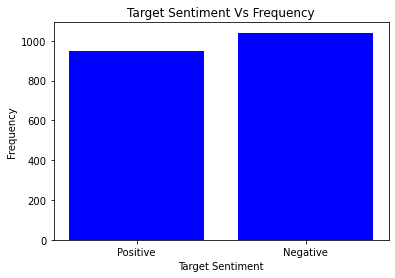

In [12]:
x=list(dic.keys())
y=list(dic.values())
plt.bar(range(len(dic)),y,tick_label=x,color='blue')
plt.title('Target Sentiment Vs Frequency')
plt.xlabel('Target Sentiment')
plt.ylabel('Frequency')
plt.show()

Data Pre-Processing 

Converting text into lowercase

In [13]:
def convert_lowercase(sent):
    sent=sent.lower()
    return sent

In [14]:
data['OriginalTweet']=data['OriginalTweet'].apply(convert_lowercase)

Removing punctuations in text column

In [15]:
def remove_punctuation(sen):
    for punctuations in string.punctuation:
        sen=sen.replace(punctuations,'')
    return sen

In [16]:
data['OriginalTweet']=data['OriginalTweet'].apply(remove_punctuation)

Convert Number to Words

In [17]:
def num_to_words(text):
    # splitting text into words with space
    after_spliting = text.split()

    for index in range(len(after_spliting)):
        if after_spliting[index].isdigit():
            after_spliting[index] = num2words(after_spliting[index])

    # joining list into string with space
    numbers_to_words = ' '.join(after_spliting)
    return numbers_to_words

In [18]:
data['OriginalTweet']=data['OriginalTweet'].apply(num_to_words)

Again removing punctuation due to applying number to word function, It may contain '-' between words

In [19]:
data['OriginalTweet']=data['OriginalTweet'].apply(remove_punctuation)

In [20]:
data.head(10)

,OriginalTweet,Sentiment
0,when i couldnt find hand sanitizer at fred mey...,Positive
1,panic buying hits newyork city as anxious shop...,Negative
2,voting in the age of coronavirus hand sanitize...,Positive
3,best quality couches at unbelievably low price...,Positive
4,while we were busy watching election returns a...,Positive
5,thats about a week from now a bit optimistic p...,Positive
6,coronavirus covid19 people are starting to bec...,Negative
7,alright yall i hope our melanin prevails but ...,Positive
8,when your usual grocery shopping woolworths tu...,Negative
9,coronavirus panic spreads costco is pulling fr...,Negative


Convert Accented Characters to ASCII Characters

In [21]:
def to_ascii(text):
    text = unidecode.unidecode(text)
    return text

In [22]:
data['OriginalTweet']=data['OriginalTweet'].apply(to_ascii)

In [23]:
data.head(10)

,OriginalTweet,Sentiment
0,when i couldnt find hand sanitizer at fred mey...,Positive
1,panic buying hits newyork city as anxious shop...,Negative
2,voting in the age of coronavirus hand sanitize...,Positive
3,best quality couches at unbelievably low price...,Positive
4,while we were busy watching election returns a...,Positive
5,thats about a week from now a bit optimistic p...,Positive
6,coronavirus covid19 people are starting to bec...,Negative
7,alright yall i hope our melanin prevails but j...,Positive
8,when your usual grocery shopping woolworths tu...,Negative
9,coronavirus panic spreads costco is pulling fr...,Negative


Removing Stopwords from Text

In [24]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [25]:
data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Lemmetizing the text

In [26]:
lemma = WordNetLemmatizer()
def lemmatization(text):

    # word tokenization
    tokens = word_tokenize(text)

    for index in range(len(tokens)):
        # lemma word
        lemma_word = lemma.lemmatize(tokens[index])
        tokens[index] = lemma_word

    return ' '.join(tokens)

In [27]:
data['OriginalTweet']=data['OriginalTweet'].apply(lemmatization)

In [28]:
data

,OriginalTweet,Sentiment
0,couldnt find hand sanitizer fred meyer turned ...,Positive
1,panic buying hit newyork city anxious shopper ...,Negative
2,voting age coronavirus hand sanitizer supertue...,Positive
3,best quality couch unbelievably low price avai...,Positive
4,busy watching election return bracing covid19 ...,Positive
...,...,...
1983,kpiti new world busy staff say way since covid...,Positive
1984,even though law library closed subscriber acce...,Positive
1985,ricepolitics mdcounties craig call general ass...,Negative
1986,meanwhile supermarket israel people dance sing...,Positive


Label Encoding

In [29]:
label={'Positive':1,'Negative':0}
def labelencode(x):
    return label[x]

In [30]:
data['Sentiment']=data['Sentiment'].apply(labelencode)

In [31]:
data.head(10)

,OriginalTweet,Sentiment
0,couldnt find hand sanitizer fred meyer turned ...,1
1,panic buying hit newyork city anxious shopper ...,0
2,voting age coronavirus hand sanitizer supertue...,1
3,best quality couch unbelievably low price avai...,1
4,busy watching election return bracing covid19 ...,1
5,thats week bit optimistic probably take anothe...,1
6,coronavirus covid19 people starting become fri...,0
7,alright yall hope melanin prevails case took p...,1
8,usual grocery shopping woolworth turn toilet p...,0
9,coronavirus panic spread costco pulling free s...,0


Train Test Split

In [32]:
x=data['OriginalTweet']
y=data['Sentiment']

In [33]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=101)

TF-IDF Vectorizer to Convert a text into a Vector

In [34]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

In [35]:
tfidf_train.shape,tfidf_test.shape

((1391, 6623), (597, 6623))

Classification Models

Logistics Regression

In [36]:
lr=LogisticRegression(random_state=0)
lr.fit(tfidf_train,y_train)
yprediction1=lr.predict(tfidf_test)

In [37]:
print("Accuracy Percentage ",round(accuracy_score(yprediction1,y_test),2))

Accuracy Percentage  0.64


In [38]:
print(classification_report(yprediction1, y_test))

              precision    recall  f1-score   support

           0       0.73      0.65      0.68       359
           1       0.54      0.63      0.59       238

    accuracy                           0.64       597
   macro avg       0.64      0.64      0.63       597
weighted avg       0.65      0.64      0.64       597



In [39]:
cf1 = confusion_matrix(yprediction1,y_test, labels = [1,0])
cf1

array([[151,  87],
       [127, 232]], dtype=int64)

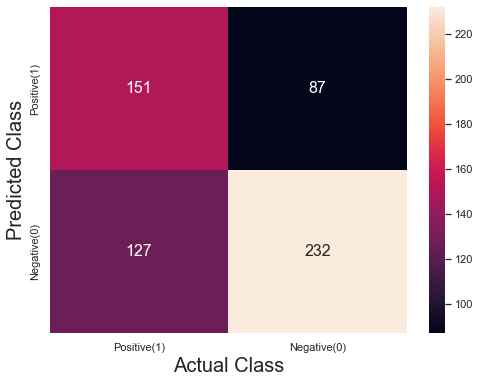

In [40]:
x_axis_labels = ["Positive(1)","Negative(0)"]
y_axis_labels = ["Positive(1)","Negative(0)"]

plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(cf1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, fmt='g',annot_kws = {'size': 16})
plt.xlabel("Actual Class", fontsize = 20)
plt.ylabel("Predicted Class", fontsize = 20)
plt.show()

Naive Bayes Classifier

In [41]:
model_naive = naive_bayes.MultinomialNB()
model_naive.fit(tfidf_train, y_train)
yprediction2=model_naive.predict(tfidf_test)

In [42]:
print("Accuracy Percentage ",round(accuracy_score(yprediction2,y_test),2))

Accuracy Percentage  0.62


In [43]:
print(classification_report(yprediction2, y_test))

              precision    recall  f1-score   support

           0       0.80      0.61      0.69       415
           1       0.42      0.65      0.51       182

    accuracy                           0.62       597
   macro avg       0.61      0.63      0.60       597
weighted avg       0.69      0.62      0.64       597



In [44]:
cf2 = confusion_matrix(yprediction2,y_test, labels = [1,0])
cf2

array([[118,  64],
       [160, 255]], dtype=int64)

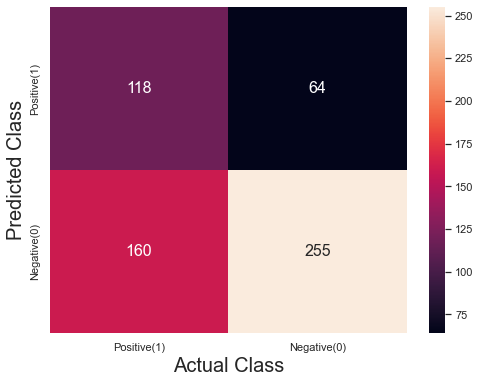

In [45]:
x_axis_labels = ["Positive(1)","Negative(0)"]
y_axis_labels = ["Positive(1)","Negative(0)"]

plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(cf2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, fmt='g',annot_kws = {'size': 16})
plt.xlabel("Actual Class", fontsize = 20)
plt.ylabel("Predicted Class", fontsize = 20)
plt.show()

Decision Tree Classifier

In [46]:
dt=DecisionTreeClassifier(random_state=0)
dt.fit(tfidf_train,y_train)
yprediction3=dt.predict(tfidf_test)

In [47]:
print("Accuracy Percentage ",round(accuracy_score(yprediction3,y_test),2))

Accuracy Percentage  0.56


In [48]:
print(classification_report(yprediction3, y_test))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       327
           1       0.51      0.53      0.52       270

    accuracy                           0.56       597
   macro avg       0.55      0.56      0.55       597
weighted avg       0.56      0.56      0.56       597



In [49]:
cf3 = confusion_matrix(yprediction3,y_test, labels = [1,0])
cf3

array([[142, 128],
       [136, 191]], dtype=int64)

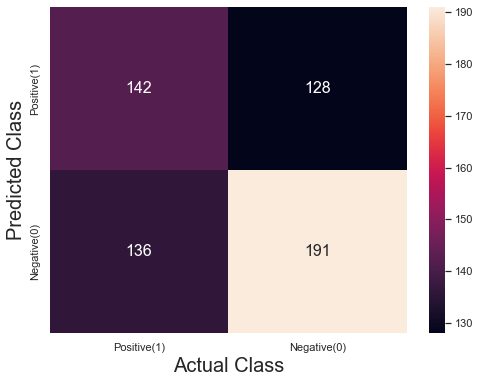

In [50]:
x_axis_labels = ["Positive(1)","Negative(0)"]
y_axis_labels = ["Positive(1)","Negative(0)"]

plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(cf3, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, fmt='g',annot_kws = {'size': 16})
plt.xlabel("Actual Class", fontsize = 20)
plt.ylabel("Predicted Class", fontsize = 20)
plt.show()

Random Forest Classifier

In [51]:
rf=RandomForestClassifier(n_estimators=50)
rf.fit(tfidf_train,y_train)
yprediction4=rf.predict(tfidf_test)

In [52]:
print("Accuracy Percentage ",round(accuracy_score(yprediction4,y_test),2))

Accuracy Percentage  0.61


In [53]:
print(classification_report(yprediction4, y_test))

              precision    recall  f1-score   support

           0       0.73      0.61      0.67       384
           1       0.46      0.60      0.52       213

    accuracy                           0.61       597
   macro avg       0.60      0.61      0.59       597
weighted avg       0.64      0.61      0.61       597



In [54]:
cf4 = confusion_matrix(yprediction4,y_test, labels = [1,0])
cf4

array([[128,  85],
       [150, 234]], dtype=int64)

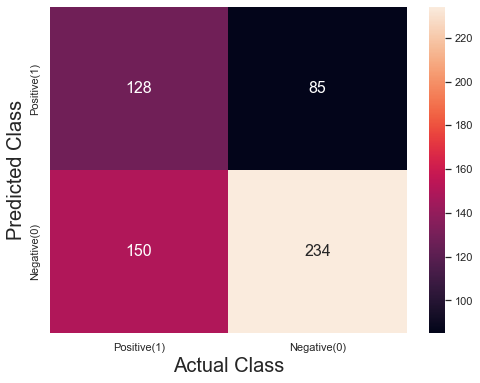

In [55]:
x_axis_labels = ["Positive(1)","Negative(0)"]
y_axis_labels = ["Positive(1)","Negative(0)"]

plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(cf4, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, fmt='g',annot_kws = {'size': 16})
plt.xlabel("Actual Class", fontsize = 20)
plt.ylabel("Predicted Class", fontsize = 20)
plt.show()

Support Vector Machine

In [56]:
svm=LinearSVC()
svm.fit(tfidf_train,y_train)
yprediction5=svm.predict(tfidf_test)

In [57]:
print("Accuracy Percentage ",round(accuracy_score(yprediction5,y_test),2))

Accuracy Percentage  0.65


In [58]:
print(classification_report(yprediction5, y_test))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69       359
           1       0.55      0.64      0.59       238

    accuracy                           0.65       597
   macro avg       0.64      0.65      0.64       597
weighted avg       0.66      0.65      0.65       597



In [59]:
cf5 = confusion_matrix(yprediction5,y_test, labels = [1,0])
cf5

array([[153,  85],
       [125, 234]], dtype=int64)

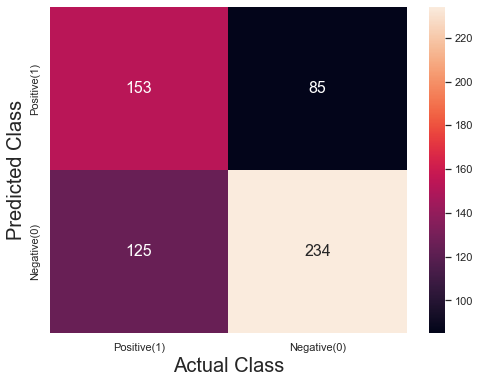

In [60]:
x_axis_labels = ["Positive(1)","Negative(0)"]
y_axis_labels = ["Positive(1)","Negative(0)"]

plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(cf5, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, fmt='g',annot_kws = {'size': 16})
plt.xlabel("Actual Class", fontsize = 20)
plt.ylabel("Predicted Class", fontsize = 20)
plt.show()

Passive Agressive Classifier

In [61]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
yprediction6=pac.predict(tfidf_test)

In [62]:
print("Accuracy Percentage ",round(accuracy_score(yprediction6,y_test),2))

Accuracy Percentage  0.63


In [63]:
print(classification_report(yprediction6, y_test))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       348
           1       0.55      0.62      0.58       249

    accuracy                           0.63       597
   macro avg       0.63      0.63      0.63       597
weighted avg       0.64      0.63      0.64       597



In [64]:
cf6 = confusion_matrix(yprediction6,y_test, labels = [1,0])
cf6

array([[154,  95],
       [124, 224]], dtype=int64)

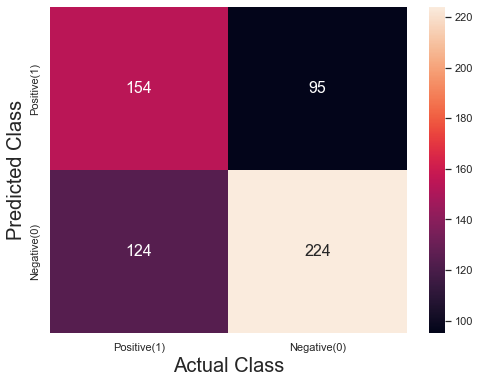

In [65]:
x_axis_labels = ["Positive(1)","Negative(0)"]
y_axis_labels = ["Positive(1)","Negative(0)"]

plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(cf6, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, fmt='g',annot_kws = {'size': 16})
plt.xlabel("Actual Class", fontsize = 20)
plt.ylabel("Predicted Class", fontsize = 20)
plt.show()